In [1]:
import polars as pl
from datetime import datetime
from typing import Tuple, List
import warnings
import sys
import numpy as np
import scipy
import statsmodels.api as sm
from production.alpha101_prod import CalcAlpha101Factor

POS_RET_PCT_SCALE_THRESHOLD = 0.01

input_path = "data/all_data_1d.parquet"
output_path = "data/alpha2_pred.parquet"
is_prod = False

In [2]:
def undimensionalize(data, column_name, window = 50):
    data = data.with_columns((pl.col(column_name) / pl.col(column_name).rolling_mean(window) - 1).over('symbol').alias(column_name))
    return data

def standardize_z(data, column_name):
    data = data.with_columns(((pl.col(column_name) - pl.col(column_name).mean()) / pl.col(column_name).std()).over('open_time')
        .alias(column_name))
    return data
def sign(column):
    return pl.when(column > 0).then(1).otherwise(pl.when(column < 0).then(-1).otherwise(0))

In [3]:
def AddPastReturnFactor(input_df: pl.DataFrame, day_num: int) -> pl.DataFrame:
    input_df = input_df.sort(["symbol", "open_time"])
    # 千万注意，这里是计算此时刻相对于前一时刻的return，不能使用未来信息 -> shift(1)是整体往下移动
    for i in range(1, day_num + 1):
        input_df = input_df.with_columns(
            ((pl.col("close") / pl.col("close").shift(i) - 1) * 100)
            .over("symbol")  # Applying the function over each symbol group
            .alias(f"past_{i}day_close_return")
        )

    # 默认使用过去1天的return作为return列
    input_df = input_df.with_columns(pl.col("past_1day_close_return").alias("return"))

    return input_df

In [4]:
def CalcDayPositionScale(
    input_df: pl.DataFrame, day_num: int, trade_long_rank: int, trade_short_rank: int
) -> pl.DataFrame:
    # print(input_df["linear_compound_factor_1day"])
    agg_avg_ret_list = []
    for i in range(1, day_num + 1):
        for side in ["long", "short"]:
            sort_desc = True if side == "long" else False
            trade_rank_num = trade_long_rank if side == "long" else trade_short_rank

            input_df = input_df.with_columns(
                pl.col(f"linear_compound_factor_{i}day")
                .rank(descending=sort_desc)
                .over("open_time")
                .alias(f"symbol_rank_{side}_{i}day")
            ).with_columns(
                pl.when(pl.col(f"symbol_rank_{side}_{i}day") <= trade_rank_num)
                .then(pl.col(f"close_price_fut_{i}day_ret"))
                .otherwise(None)
                .alias(f"total_{side}_value_scale_{i}day")
            )

            cur_agg_avg_ret = (
                input_df.group_by("open_time")
                .agg(
                    pl.col(f"total_{side}_value_scale_{i}day")
                    .mean()
                    .alias(f"fut_mean_{side}_ret_{i}day"),
                )
                .sort("open_time")
            )
            agg_avg_ret_list.append(cur_agg_avg_ret)

    agg_avg_ret_df = agg_avg_ret_list[0]
    for df in agg_avg_ret_list[1:]:
        agg_avg_ret_df = agg_avg_ret_df.join(df, on="open_time", how="right")

    # Sort the final DataFrame by open_time
    agg_avg_ret_df = agg_avg_ret_df.sort("open_time")
    agg_avg_ret_df = agg_avg_ret_df.select(
        pl.col(
            ["open_time"]
            + [col for col in agg_avg_ret_df.columns if col != "open_time"]
        )
    )

    for i in range(1, day_num + 1):
        for side in ["long", "short"]:
            agg_avg_ret_df = agg_avg_ret_df.with_columns(
                pl.col(f"fut_mean_{side}_ret_{i}day")
                .shift(i)
                .alias(f"past_mean_{side}_ret_{i}day"),
            )

    for i in range(1, day_num + 1):
        for side in ["long", "short"]:
            bullish_scale = 1.2 if side == "long" else 0.8
            bearish_scale = 0.8 if side == "long" else 1.2
            agg_avg_ret_df = agg_avg_ret_df.with_columns(
                pl.when(
                    (pl.col(f"past_mean_long_ret_{i}day") > POS_RET_PCT_SCALE_THRESHOLD)
                    & (
                        pl.col(f"past_mean_short_ret_{i}day")
                        > POS_RET_PCT_SCALE_THRESHOLD
                    )
                )
                .then(bullish_scale)
                .when(
                    (pl.col(f"past_mean_long_ret_{i}day") < POS_RET_PCT_SCALE_THRESHOLD)
                    & (
                        pl.col(f"past_mean_short_ret_{i}day")
                        < POS_RET_PCT_SCALE_THRESHOLD
                    )
                )
                .then(bearish_scale)
                .otherwise(1.0)
                .alias(f"{side}_value_scale_{i}day")
            )
    return input_df, agg_avg_ret_df


In [5]:
def AddTotalPosValueScale(
    input_df: pl.DataFrame, day_num: int, trade_long_rank: int, trade_short_rank: int
) -> pl.DataFrame:
    _, day_scale_df = CalcDayPositionScale(
        input_df, day_num, trade_long_rank, trade_short_rank
    )

    # only need the scale columns
    select_col = [col for col in day_scale_df.columns if "scale" in col]
    day_scale_df = day_scale_df.select(pl.col(["open_time"] + select_col))

    # print(f"before join: {input_df}")
    # print(f"day scale df: ", day_scale_df)

    input_df = input_df.join(day_scale_df, on="open_time", how="left")

    # print(f"after join     : {input_df}")
    return input_df, day_scale_df


In [6]:
def AddAmihud(input_df: pl.DataFrame, window_size: int = 10) -> pl.DataFrame:
    # Calculate rolling sums for absolute returns and quote volume
    input_df = input_df.with_columns(
        pl.col("return").abs().rolling_sum(window_size=window_size).over("symbol").alias("rolling_abs_return_sum"),
        pl.col("quote_volume").rolling_sum(window_size=window_size).over("symbol").alias("rolling_quote_volume_sum"),
    )

    # Calculate Amihud illiquidity measure
    input_df = input_df.with_columns(
        (pl.col("rolling_abs_return_sum") / pl.col("rolling_quote_volume_sum"))
        .over("symbol")  # Apply the final operation within each symbol group
        .alias("amihud")
    )

    # Drop intermediate columns
    input_df = input_df.drop(["rolling_abs_return_sum", "rolling_quote_volume_sum"])

    return input_df

In [7]:
def AddReturnAutocorr(input_df: pl.DataFrame, window_size: int = 20, lag: int = 1) -> pl.DataFrame:
    # Calculate rolling sums for absolute returns and quote volume
    input_df = input_df.with_columns(
        pl.rolling_corr(pl.col("return"), pl.col("return").shift(1), window_size=window_size).over("symbol").alias("return_autocorr_" + str(lag))
    )
    return input_df

In [8]:
def AddReturnSkewness(input_df: pl.DataFrame, window_size: int = 20) -> pl.DataFrame:
    # Calculate rolling sums for absolute returns and quote volume
    input_df = input_df.with_columns(
        pl.col("return").rolling_skew(window_size).over("symbol").alias("return_skewness")
    )
    return input_df

In [9]:
def AddTakerBuyRatio(input_df: pl.DataFrame) -> pl.DataFrame:
    input_df = input_df.with_columns(
        (pl.col("taker_buy_volume") / pl.col("volume")).over('symbol').alias("taker_buy_ratio")
    )
    return input_df

In [10]:
def AddID(input_df: pl.DataFrame) -> pl.DataFrame:
    input_df = input_df.with_columns((pl.col('close') / pl.col('open') - 1).over('symbol').alias('ret1'))
    input_df = input_df.sort(by=['symbol', 'open_time'])

    # 计算过去 3天的最大涨幅和最小涨幅
    max_return = pl.col("ret1").rolling_max(window_size=48)
    min_return = pl.col("ret1").rolling_min(window_size=48)
    # 计算 ID
    input_df = input_df.with_columns(
        (sign(pl.col('ret1'))
        * (pl.col("ret1").rolling_max(window_size=48) - pl.col("ret1").rolling_min(window_size=72)) / pl.col('close'))
        .over('symbol')
        .alias("ID")
    )
    input_df = input_df.with_columns(
        pl.col('ID').clip(-0.2, 0.3).alias('ID')
    )
    input_df = input_df.drop('ret1')
    return input_df

In [11]:
def AddAutocorrRank(input_df: pl.DataFrame, window_size: int = 3) -> pl.DataFrame:
    input_df = input_df.with_columns(
        pl.col('close').shift(2).over('symbol').alias('shift_close2')
    )
    input_df = input_df.with_columns([
        pl.col("close").rank().over("symbol").alias("rank_close"),
        pl.col("shift_close2").rank().over("symbol").alias("rank_shift_close2")
    ])
    # 计算排名后的滚动Pearson相关系数，实际上就是滚动的Spearman相关系数
    input_df = input_df.with_columns(
        pl.rolling_corr("rank_close", "rank_shift_close2", window_size=6)
        .over("symbol")
        .alias("spearman_corr2_w3")
    )
    input_df = input_df.drop(["shift_close2","rank_close","rank_shift_close2"])
    return input_df

In [12]:
def beat_ratio(input_df: pl.DataFrame) -> pl.DataFrame:
    input_df = input_df.with_columns([
    (pl.col("quote_volume") - pl.col('taker_buy_quote_volume')).alias("taker_sell_quote_volume")
    ])

    input_df = input_df.with_columns([
        (pl.col("taker_buy_quote_volume") / pl.col("taker_sell_quote_volume")).alias("beat_ratio")
    ])

    return input_df

In [13]:
def factor011(input_df: pl.DataFrame, x1: int, x2: int) -> pl.DataFrame:
    
    input_df = input_df.with_columns([
        (pl.col('quote_volume') / pl.col('volume')).alias('vwap'),
        (pl.col('volume') - (pl.col('volume').shift(x1).over('symbol'))).alias('volume_change')
    ])

    input_df = input_df.with_columns([
        (pl.col('vwap') - pl.col('close')).rolling_max(x2).over('symbol').alias('vwap_close_max'),
        (pl.col('vwap') - pl.col('close')).rolling_min(x2).over('symbol').alias('vwap_close_min')
    ])

    input_df = input_df.with_columns([
        pl.col('vwap_close_max').rank('dense').over('open_time').alias('vwap_close_max_rank'),
        pl.col('vwap_close_min').rank('dense').over('open_time').alias('vwap_close_min_rank'),
        pl.col('volume_change').rank('dense').over('open_time').alias('volume_change_rank')
    ])

    input_df = input_df.with_columns([
        (pl.col('vwap_close_max_rank') + pl.col('vwap_close_min_rank') * pl.col('volume_change_rank')).alias('factor011_rank')
    ])

    return input_df

In [14]:
def nettotal_taker_quote_volume(input_df: pl.DataFrame, N: int) -> pl.DataFrame:

    input_df = input_df.with_columns([
        (pl.col('quote_volume') - pl.col('taker_buy_quote_volume')).alias('taker_sell_quote_volume')
    ])

    input_df = input_df.with_columns([
        pl.col('taker_buy_quote_volume').rolling_sum(N).over('symbol').alias('taker_buy_quote_volume_sum'),
        pl.col('taker_sell_quote_volume').rolling_sum(N).over('symbol').alias('taker_sell_quote_volume_sum'),
    ])

    input_df = input_df.with_columns([
        (pl.col('taker_buy_quote_volume_sum') - pl.col('taker_sell_quote_volume_sum')).alias('net_taker_quote_volume'),
        (pl.col('taker_buy_quote_volume_sum') + pl.col('taker_sell_quote_volume_sum')).alias('total_taker_quote_volume')
    ])

    return input_df

In [15]:
def AddFutureRetCol(input_df: pl.DataFrame, day_num: int) -> pl.DataFrame:
    input_df = input_df.sort(["symbol", "open_time"])
    for i in range(1, day_num + 1):
        input_df = input_df.with_columns(
            ((pl.col("close").shift(-i) / pl.col("close") - 1) * 100)
            .over("symbol")  # Applying the function over each symbol group
            .alias(f"close_price_fut_{i}day_ret")
        )
        input_df = input_df.with_columns(
            ((pl.col("open").shift(-i) / pl.col("open") - 1) * 100)
            .over("symbol")  # Applying the function over each symbol group
            .alias(f"open_price_fut_{i}day_ret")
        )
    return input_df

In [16]:
def fama_macbeth_get_factor_weight(
    train_data: pl.DataFrame,
    update_pos_days: int,
    factor_num: int,
    factor_combination_list: List[str],
) -> Tuple[np.ndarray, float]:
    # Drop rows containing any null values
    train_data = train_data.drop_nulls()

    total_weights_sum = np.zeros(factor_num)
    unique_times = train_data.select(pl.col("open_time").sort()).unique().to_numpy()

    constant_sum = 0.0

    for each_time in unique_times:
        y_column_name = f"close_price_fut_{update_pos_days}day_ret"
        assert (
            y_column_name in train_data.columns
        ), f"Column {y_column_name} (as y) not found in train data"

        slice_data = train_data.filter(pl.col("open_time") == each_time).fill_nan(0)

        X = slice_data[factor_combination_list].to_numpy()
        X = sm.add_constant(X)  # Add constant term (intercept)
        y = slice_data[y_column_name].to_numpy()

        model = sm.OLS(y, X)
        results = model.fit()
        weights = results.params[1:]
        # print(results.params[1:])
        constant_sum += results.params[0]  # constant term

        while weights.shape[0] < total_weights_sum.shape[0]:
            weights = np.append(weights, 0)

        total_weights_sum += weights
        print(total_weights_sum)

    total_weights_sum /= len(unique_times)
    avg_const_term = constant_sum / len(unique_times)

    return total_weights_sum, avg_const_term


In [17]:
def CalcLinearCompoundFactor(
    input_df: pl.DataFrame,
    day_num: int,
    factor_combination_list: list,
    date_threshold: datetime = datetime(2023, 1, 1),
) -> pl.DataFrame:

    factor_num = len(factor_combination_list)

    for cur_update_position_time in range(1, day_num + 1):
        cur_fut_ret_column_name = f"close_price_fut_{cur_update_position_time}day_ret"

        non_nan_result = input_df.filter(
            (pl.col(cur_fut_ret_column_name).is_not_nan())
            & (pl.col(cur_fut_ret_column_name).is_not_null())
        ).sort(["open_time", "symbol"])

        non_nan_linear_x = non_nan_result.select(
            ["open_time", "symbol", cur_fut_ret_column_name] + factor_combination_list
        )

        date_threshold_ms = date_threshold.timestamp() * 1000
        linear_x_train = non_nan_linear_x.filter(
            pl.col("open_time") < date_threshold_ms
        )

        # # 检查过确实只使用训练数据拟合，没有用测试信息
        # print(linear_x_train.sort(by="open_time"))

        weighted_factors, const_term = fama_macbeth_get_factor_weight(
            linear_x_train,
            cur_update_position_time,
            factor_num=factor_num,
            factor_combination_list=factor_combination_list,
        )

        weighted_sum_expr = pl.lit(const_term)
        for factor, weight in zip(factor_combination_list, weighted_factors):
            weighted_sum_expr += pl.col(factor) * weight

        # 这个代码用于实际交易的时候，我们只需要使用权重计算未来收益率
        input_df = input_df.with_columns(
            weighted_sum_expr.alias(
                f"linear_compound_factor_{cur_update_position_time}day"
            )
        )

    return input_df.filter(
        pl.col("open_time") >= date_threshold_ms
    )  # only return the data after the threshold


In [18]:
def AddVolatilityCol(input_df: pl.DataFrame) -> pl.DataFrame:
    def calculate_volatility(group, bar_name: str, window_size: int = 30):
        return group.with_columns(
            [
                pl.col(bar_name)
                .pct_change()
                .rolling_std(window_size=window_size)
                .alias(f"{bar_name}_price_volatility")
            ]
        )

    input_df = input_df.group_by("symbol").map_groups(
        lambda x: calculate_volatility(x, "open", window_size=30)
    )
    input_df = input_df.group_by("symbol").map_groups(
        lambda x: calculate_volatility(x, "close", window_size=30)
    )
    return input_df

In [19]:
FACTOR_COMBINATION_LIST = [
    "amihud",
    "return_skewness",
    "alpha30",
    "alpha36",
    "alpha40",
    "alpha45",
    'net_taker_quote_volume',
]
UPDATE_POSITION_TIME = 10

input_data = pl.read_parquet(input_path)
input_data = input_data.with_columns(pl.from_epoch(pl.col("open_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("open_time"))
input_data = input_data.with_columns(pl.from_epoch(pl.col("close_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("close_time"))
input_data = input_data.sort(by=["symbol", "open_time"])

# for production need
input_data = input_data.filter(
    ~pl.col("symbol").is_in(
        ["BTCUSDT", "ETHUSDT", "BCHUSDT", "LTCUSDT", "ETCUSDT", "LINKUSDT", "AVAXUSDT", "SOLUSDT"]
    )
).filter(pl.col("symbol").str.ends_with("USDT"))

input_data = AddPastReturnFactor(input_data, day_num=10)
input_data = AddVolatilityCol(input_data)
input_data = AddAmihud(input_data)
# input_data = AddReturnAutocorr(input_data, 28, 1)
input_data = AddReturnSkewness(input_data, 7)
# input_data = AddTakerBuyRatio(input_data)  # 1.666
# input_data = AddID(input_data)  # 1.895
# input_data = AddAutocorrRank(input_data)  # 1.371
# input_data = beat_ratio(input_data)  # 1.540
# input_data = factor011(input_data, 60, 65)  # 1.980
input_data = nettotal_taker_quote_volume(input_data, 20)  # 1.634

# Calculate alpha101 factor
alpha101_factor_list = [x for x in FACTOR_COMBINATION_LIST if "alpha" in x]
input_data = CalcAlpha101Factor(input_data, calc_factor_list=alpha101_factor_list)

input_data

alpha30
alpha36
alpha40
alpha45


symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,past_1day_close_return,past_2day_close_return,past_3day_close_return,past_4day_close_return,past_5day_close_return,past_6day_close_return,past_7day_close_return,past_8day_close_return,past_9day_close_return,past_10day_close_return,return,open_price_volatility,close_price_volatility,amihud,return_skewness,taker_sell_quote_volume,taker_buy_quote_volume_sum,taker_sell_quote_volume_sum,net_taker_quote_volume,total_taker_quote_volume,alpha30,alpha36,alpha40,alpha45
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DYMUSDT""",2024-02-07 00:00:00,5.244,6.353,4.895,5.731,6.0717e7,2024-02-07 23:59:59.999,3.5328e8,1441293,3.0698e7,1.7860e8,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.7468e8,null,null,null,null,0.0,0.0,0.0,0.0
"""DYMUSDT""",2024-02-08 00:00:00,5.733,8.357,5.699,7.272,1.5740e8,2024-02-08 23:59:59.999,1.1345e9,3795274,7.9951926e7,5.7604e8,26.88885,null,null,null,null,null,null,null,null,null,26.88885,null,null,null,null,5.5845e8,null,null,null,null,0.0,0.0,0.0,0.0
"""DYMUSDT""",2024-02-09 00:00:00,7.272,8.281,6.882,7.314,1.2149e8,2024-02-09 23:59:59.999,9.1663e8,3665679,6.0438e7,4.5636e8,0.577558,27.621707,null,null,null,null,null,null,null,null,0.577558,null,null,null,null,4.6027e8,null,null,null,null,0.0,0.0,0.0,0.0
"""DYMUSDT""",2024-02-10 00:00:00,7.315,7.738,7.078,7.457,4.4941e7,2024-02-10 23:59:59.999,3.3559e8,1494194,2.2125e7,1.6526e8,1.955154,2.544004,30.116908,null,null,null,null,null,null,null,1.955154,null,null,null,null,1.7033e8,null,null,null,null,0.0,0.0,0.0,0.0
"""DYMUSDT""",2024-02-11 00:00:00,7.458,7.86,7.054,7.111,3.1214e7,2024-02-11 23:59:59.999,2.3460e8,1155757,1.4954e7,1.1249e8,-4.639936,-2.775499,-2.213971,24.079567,null,null,null,null,null,null,-4.639936,null,null,null,null,1.2211e8,null,null,null,null,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""DARUSDT""",2024-11-25 00:00:00,0.19,0.1901,0.169,0.174,1.6155e8,2024-11-25 23:59:59.999,2.8946e7,177714,7.660181e7,1.3733e7,-8.421053,3.019538,9.433962,12.258065,20.33195,10.828025,5.710814,13.948919,7.341147,13.428944,-8.421053,0.055553,0.057878,3.0213e-7,0.029467,1.5212e7,1.9866e8,2.1398e8,-1.5326e7,4.1264e8,0.130826,1.568508,-0.250241,-0.126704
"""DARUSDT""",2024-11-26 00:00:00,0.174,0.188,0.1634,0.1734,1.38333074e8,2024-11-26 23:59:59.999,2.3920e7,152993,6.6211e7,1.1447e7,-0.344828,-8.736842,2.664298,9.056604,11.870968,19.917012,10.44586,5.346294,13.555992,6.971006,-0.344828,0.057853,0.057912,2.7348e-7,-0.151486,1.2473e7,2.0301e8,2.1853e8,-1.5524e7,4.2154e8,0.194141,2.058734,-0.227935,-0.268246
"""DARUSDT""",2024-11-27 00:00:00,0.1734,0.1885,0.1675,0.1879,1.0445e8,2024-11-27 23:59:59.999,1.8642e7,113505,5.1150e7,9.1321e6,8.362168,7.988506,-1.105263,11.24926,18.176101,21.225806,29.944675,19.681529,14.155529,23.051735,8.362168,0.057887,0.059572,2.8835e-7,-0.71309,9.5103e6,2.0726e8,2.2257e8,-1.5308e7,4.2983e8,0.210922,2.237646,-0.179085,0.265993


In [20]:
# 截面归一化
input_data = input_data.sort(by=["symbol", "open_time"])
original_columns = input_data.columns
for c in FACTOR_COMBINATION_LIST:
    print(c)
    input_data = input_data.with_columns(pl.col(c).mean().over("open_time").alias("mean_" + c))
    input_data = input_data.with_columns(pl.col(c).std().over("open_time").alias("std_" + c))
    input_data = input_data.with_columns(((pl.col(c) - pl.col("mean_" + c)) / pl.col("std_" + c)).alias(c))
input_data = input_data.select(original_columns)
input_data


amihud
return_skewness
alpha30
alpha36
alpha40
alpha45
net_taker_quote_volume


symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,past_1day_close_return,past_2day_close_return,past_3day_close_return,past_4day_close_return,past_5day_close_return,past_6day_close_return,past_7day_close_return,past_8day_close_return,past_9day_close_return,past_10day_close_return,return,open_price_volatility,close_price_volatility,amihud,return_skewness,taker_sell_quote_volume,taker_buy_quote_volume_sum,taker_sell_quote_volume_sum,net_taker_quote_volume,total_taker_quote_volume,alpha30,alpha36,alpha40,alpha45
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1000000MOGUSDT""",2024-11-07 00:00:00,2.0896,2.25,1.9158,2.1226,3.0109764e7,2024-11-07 23:59:59.999,6.2969e7,311739,1.4979e7,3.1363e7,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.1606e7,null,null,null,null,-1.432804,-1.774045,0.650705,-0.090856
"""1000000MOGUSDT""",2024-11-08 00:00:00,2.1229,2.1962,1.9278,2.0126,2.2044e7,2024-11-08 23:59:59.999,4.5478e7,300480,1.0508e7,2.1705e7,-5.182324,null,null,null,null,null,null,null,null,null,-5.182324,null,null,null,null,2.3772e7,null,null,null,null,-1.397557,-1.712287,0.623997,0.277767
"""1000000MOGUSDT""",2024-11-09 00:00:00,2.0126,2.1032,1.91,2.0543,1.4402e7,2024-11-09 23:59:59.999,2.8930e7,251456,6998440.5,1.4066e7,2.071947,-3.217752,null,null,null,null,null,null,null,null,2.071947,null,null,null,null,1.4864e7,null,null,null,null,-1.389125,-1.68147,0.754116,0.053496
"""1000000MOGUSDT""",2024-11-10 00:00:00,2.0542,2.2498,1.9333,2.0192,2.6371799e7,2024-11-10 23:59:59.999,5.4620e7,430257,1.2479e7,2.5866e7,-1.708611,0.327934,-4.871384,null,null,null,null,null,null,null,-1.708611,null,null,null,null,2.8754e7,null,null,null,null,-1.362452,-1.688127,1.150908,0.455895
"""1000000MOGUSDT""",2024-11-11 00:00:00,2.0197,2.1457,1.85,1.926,2.2621e7,2024-11-11 23:59:59.999,4.4398e7,346642,1.1143e7,2.1888e7,-4.615689,-6.245436,-4.302892,-9.262226,null,null,null,null,null,null,-4.615689,null,null,null,null,2.2511e7,null,null,null,null,-1.44128,-1.697067,1.205487,-0.078889
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZRXUSDT""",2024-11-25 00:00:00,0.5084,0.5137,0.4621,0.4776,7.9191e7,2024-11-25 23:59:59.999,3.9037e7,269760,3.8589e7,1.9026e7,-6.058222,3.042071,5.430464,11.406578,16.119621,9.970067,0.653319,29.747351,18.481766,32.814238,-6.058222,0.074823,0.076018,-0.213224,-0.098251,2.0011e7,3.3256e8,3.4707e8,0.22895,6.7963e8,0.275849,-0.321286,-0.217243,-0.989125
"""ZRXUSDT""",2024-11-26 00:00:00,0.4777,0.6209,0.47,0.5974,3.5806e8,2024-11-26 23:59:59.999,1.9009e8,969956,1.7885e8,9.5115e7,25.083752,17.505901,28.888889,31.87638,39.351528,45.246779,37.554686,25.900948,62.292855,48.201439,25.083752,0.076024,0.087237,-0.24933,1.209058,9.4980e7,4.2296e8,4.3702e8,0.235389,8.5998e8,-0.439517,-0.663134,-0.580862,-0.278218
"""ZRXUSDT""",2024-11-27 00:00:00,0.5974,0.6199,0.5257,0.5765,2.5114e8,2024-11-27 23:59:59.999,1.3853e8,685486,1.2160e8,6.7080e7,-3.498493,20.707705,13.394965,24.37972,27.262693,34.476324,40.165329,32.742344,21.496312,56.61505,-3.498493,0.087219,0.087781,-0.421953,1.170274,7.1452e7,4.8609e8,5.0458e8,0.223311,9.9067e8,1.617204,0.521522,-0.621677,-1.273543


In [21]:
# below for combine factors
print(f"begin to calc linear compound factor: {FACTOR_COMBINATION_LIST}")
input_data = AddFutureRetCol(input_data, UPDATE_POSITION_TIME)
input_data

input_data = CalcLinearCompoundFactor(
    input_data, UPDATE_POSITION_TIME, FACTOR_COMBINATION_LIST
)

input_data, day_scale_df = AddTotalPosValueScale(
    input_data, day_num=10, trade_long_rank=20, trade_short_rank=10
)

if is_prod:
    # for normal run, save all data
    results = input_data
else:
    # for backtest and research, remove the last few rows and symbols whose min value is larger then 5 USDT
    results = input_data.filter(pl.col("close_price_fut_7day_ret").is_not_null())
results.write_parquet(output_path)
results

begin to calc linear compound factor: ['amihud', 'return_skewness', 'alpha30', 'alpha36', 'alpha40', 'alpha45', 'net_taker_quote_volume']
[ 1.36853096e+00 -2.94443704e-01  4.47032059e-01 -1.35087676e-16
 -1.00710642e+00  0.00000000e+00 -6.21442818e-01]
[ 6.29703025e-01 -8.59570195e-01 -3.07617469e-01 -2.15250723e-16
 -9.57668745e-01  0.00000000e+00 -6.95647464e-01]
[ 3.04302556e+00  5.93384438e-01 -6.23431973e-01 -2.39800208e-16
 -1.18903816e+00  0.00000000e+00 -1.32719621e-01]
[ 2.39805487e+00  2.75381413e+00 -1.22152370e+00 -2.76433583e-15
  5.24623495e-01  0.00000000e+00  7.33686067e-01]
[ 4.62328752e+00  2.07963227e+00  3.20330677e-01 -2.39228467e-15
  4.73441750e-01  0.00000000e+00  6.53557917e-01]
[ 5.02470179e+00  3.96346092e+00 -4.78534728e-01 -6.47065757e-15
  9.43840061e-01  1.53308073e+00  1.99440715e+00]
[ 5.66018874e+00  3.98479068e+00  5.73408068e-01 -6.45115581e-15
 -6.46072249e-01  6.73329276e-01  1.45888881e+00]
[-8.32465641e-01  5.77191411e+00 -4.00231756e-02 -6.63262

symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,past_1day_close_return,past_2day_close_return,past_3day_close_return,past_4day_close_return,past_5day_close_return,past_6day_close_return,past_7day_close_return,past_8day_close_return,past_9day_close_return,past_10day_close_return,return,open_price_volatility,close_price_volatility,amihud,return_skewness,taker_sell_quote_volume,taker_buy_quote_volume_sum,taker_sell_quote_volume_sum,net_taker_quote_volume,total_taker_quote_volume,alpha30,alpha36,alpha40,alpha45,close_price_fut_1day_ret,…,open_price_fut_7day_ret,close_price_fut_8day_ret,open_price_fut_8day_ret,close_price_fut_9day_ret,open_price_fut_9day_ret,close_price_fut_10day_ret,open_price_fut_10day_ret,linear_compound_factor_1day,linear_compound_factor_2day,linear_compound_factor_3day,linear_compound_factor_4day,linear_compound_factor_5day,linear_compound_factor_6day,linear_compound_factor_7day,linear_compound_factor_8day,linear_compound_factor_9day,linear_compound_factor_10day,long_value_scale_1day,short_value_scale_1day,long_value_scale_2day,short_value_scale_2day,long_value_scale_3day,short_value_scale_3day,long_value_scale_4day,short_value_scale_4day,long_value_scale_5day,short_value_scale_5day,long_value_scale_6day,short_value_scale_6day,long_value_scale_7day,short_value_scale_7day,long_value_scale_8day,short_value_scale_8day,long_value_scale_9day,short_value_scale_9day,long_value_scale_10day,short_value_scale_10day
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1000000MOGUSDT""",2024-11-07 00:00:00,2.0896,2.25,1.9158,2.1226,3.0109764e7,2024-11-07 23:59:59.999,6.2969e7,311739,1.4979e7,3.1363e7,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.1606e7,null,null,null,null,-1.432804,-1.774045,0.650705,-0.090856,-5.182324,…,15.495789,31.758221,12.38036,25.073024,33.858155,16.24894,27.024311,null,null,null,null,null,null,null,null,null,null,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.0,1.0,1.2,0.8
"""1000000MOGUSDT""",2024-11-08 00:00:00,2.1229,2.1962,1.9278,2.0126,2.2044e7,2024-11-08 23:59:59.999,4.5478e7,300480,1.0508e7,2.1705e7,-5.182324,null,null,null,null,null,null,null,null,null,-5.182324,null,null,null,null,2.3772e7,null,null,null,null,-1.397557,-1.712287,0.623997,0.277767,2.071947,…,10.617551,31.908973,31.758444,22.602604,25.031796,18.587896,16.246644,null,null,null,null,null,null,null,null,null,null,1.0,1.0,1.0,1.0,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.0,1.0
"""1000000MOGUSDT""",2024-11-09 00:00:00,2.0126,2.1032,1.91,2.0543,1.4402e7,2024-11-09 23:59:59.999,2.8930e7,251456,6998440.5,1.4066e7,2.071947,-3.217752,null,null,null,null,null,null,null,null,2.071947,null,null,null,null,1.4864e7,null,null,null,null,-1.389125,-1.68147,0.754116,0.053496,-1.708611,…,38.97943,20.113907,31.88413,16.180694,22.61751,17.188337,18.617708,null,null,null,null,null,null,null,null,null,null,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8
"""1000000MOGUSDT""",2024-11-10 00:00:00,2.0542,2.2498,1.9333,2.0192,2.6371799e7,2024-11-10 23:59:59.999,5.4620e7,430257,1.2479e7,2.5866e7,-1.708611,0.327934,-4.871384,null,null,null,null,null,null,null,-1.708611,null,null,null,null,2.8754e7,null,null,null,null,-1.362452,-1.688127,1.150908,0.455895,-4.615689,…,29.213319,18.200277,20.134359,19.225436,16.215558,2.525753,17.140493,null,null,null,null,null,null,null,null,null,null,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8,1.2,0.8
"""1000000MOGUSDT""",2024-11-11 00:00:00,2.0197,2.1457,1.85,1.926,2.2621e7,2024-11-11 23:59:59.999,4.4398e7,346642,1.1143e7,2.1888e7,-4.615689,-6.245436,-4.302892,-9.262226,n

main_backtest ==== read result hour path: data/alpha2_pred.parquet
Polars version: 1.5.0
Pandas version: 2.0.3
NumPy version: 1.24.4
Run Backtest. Logging configured. Log file: /home/dp/backup_crypto/crypto/src/backtest/log/factor_backtest_eval_1219_1746.log
 ==== Rolling 0: Analysis={'sharpe_ratio': 1.8571058076888427, 'final_return_pct(%)': 288.05583196251035, 'max_drawdown(%)': -34.92882349657337, 'volatility': 0.41819196407158993, 'average_daily_return': 0.002208730751672775}
 ==== Rolling 1: Analysis={'sharpe_ratio': 1.368218926326961, 'final_return_pct(%)': 167.49209315393165, 'max_drawdown(%)': -49.73125873223357, 'volatility': 0.4279108768821275, 'average_daily_return': 0.0016850294785909652}
 ==== Rolling 2: Analysis={'sharpe_ratio': 1.3222168165908368, 'final_return_pct(%)': 158.76534374120698, 'max_drawdown(%)': -46.05182204515454, 'volatility': 0.4290686657342716, 'average_daily_return': 0.001635292614960153}
 ==== Rolling 3: Analysis={'sharpe_ratio': 2.0927903360300832, 'f

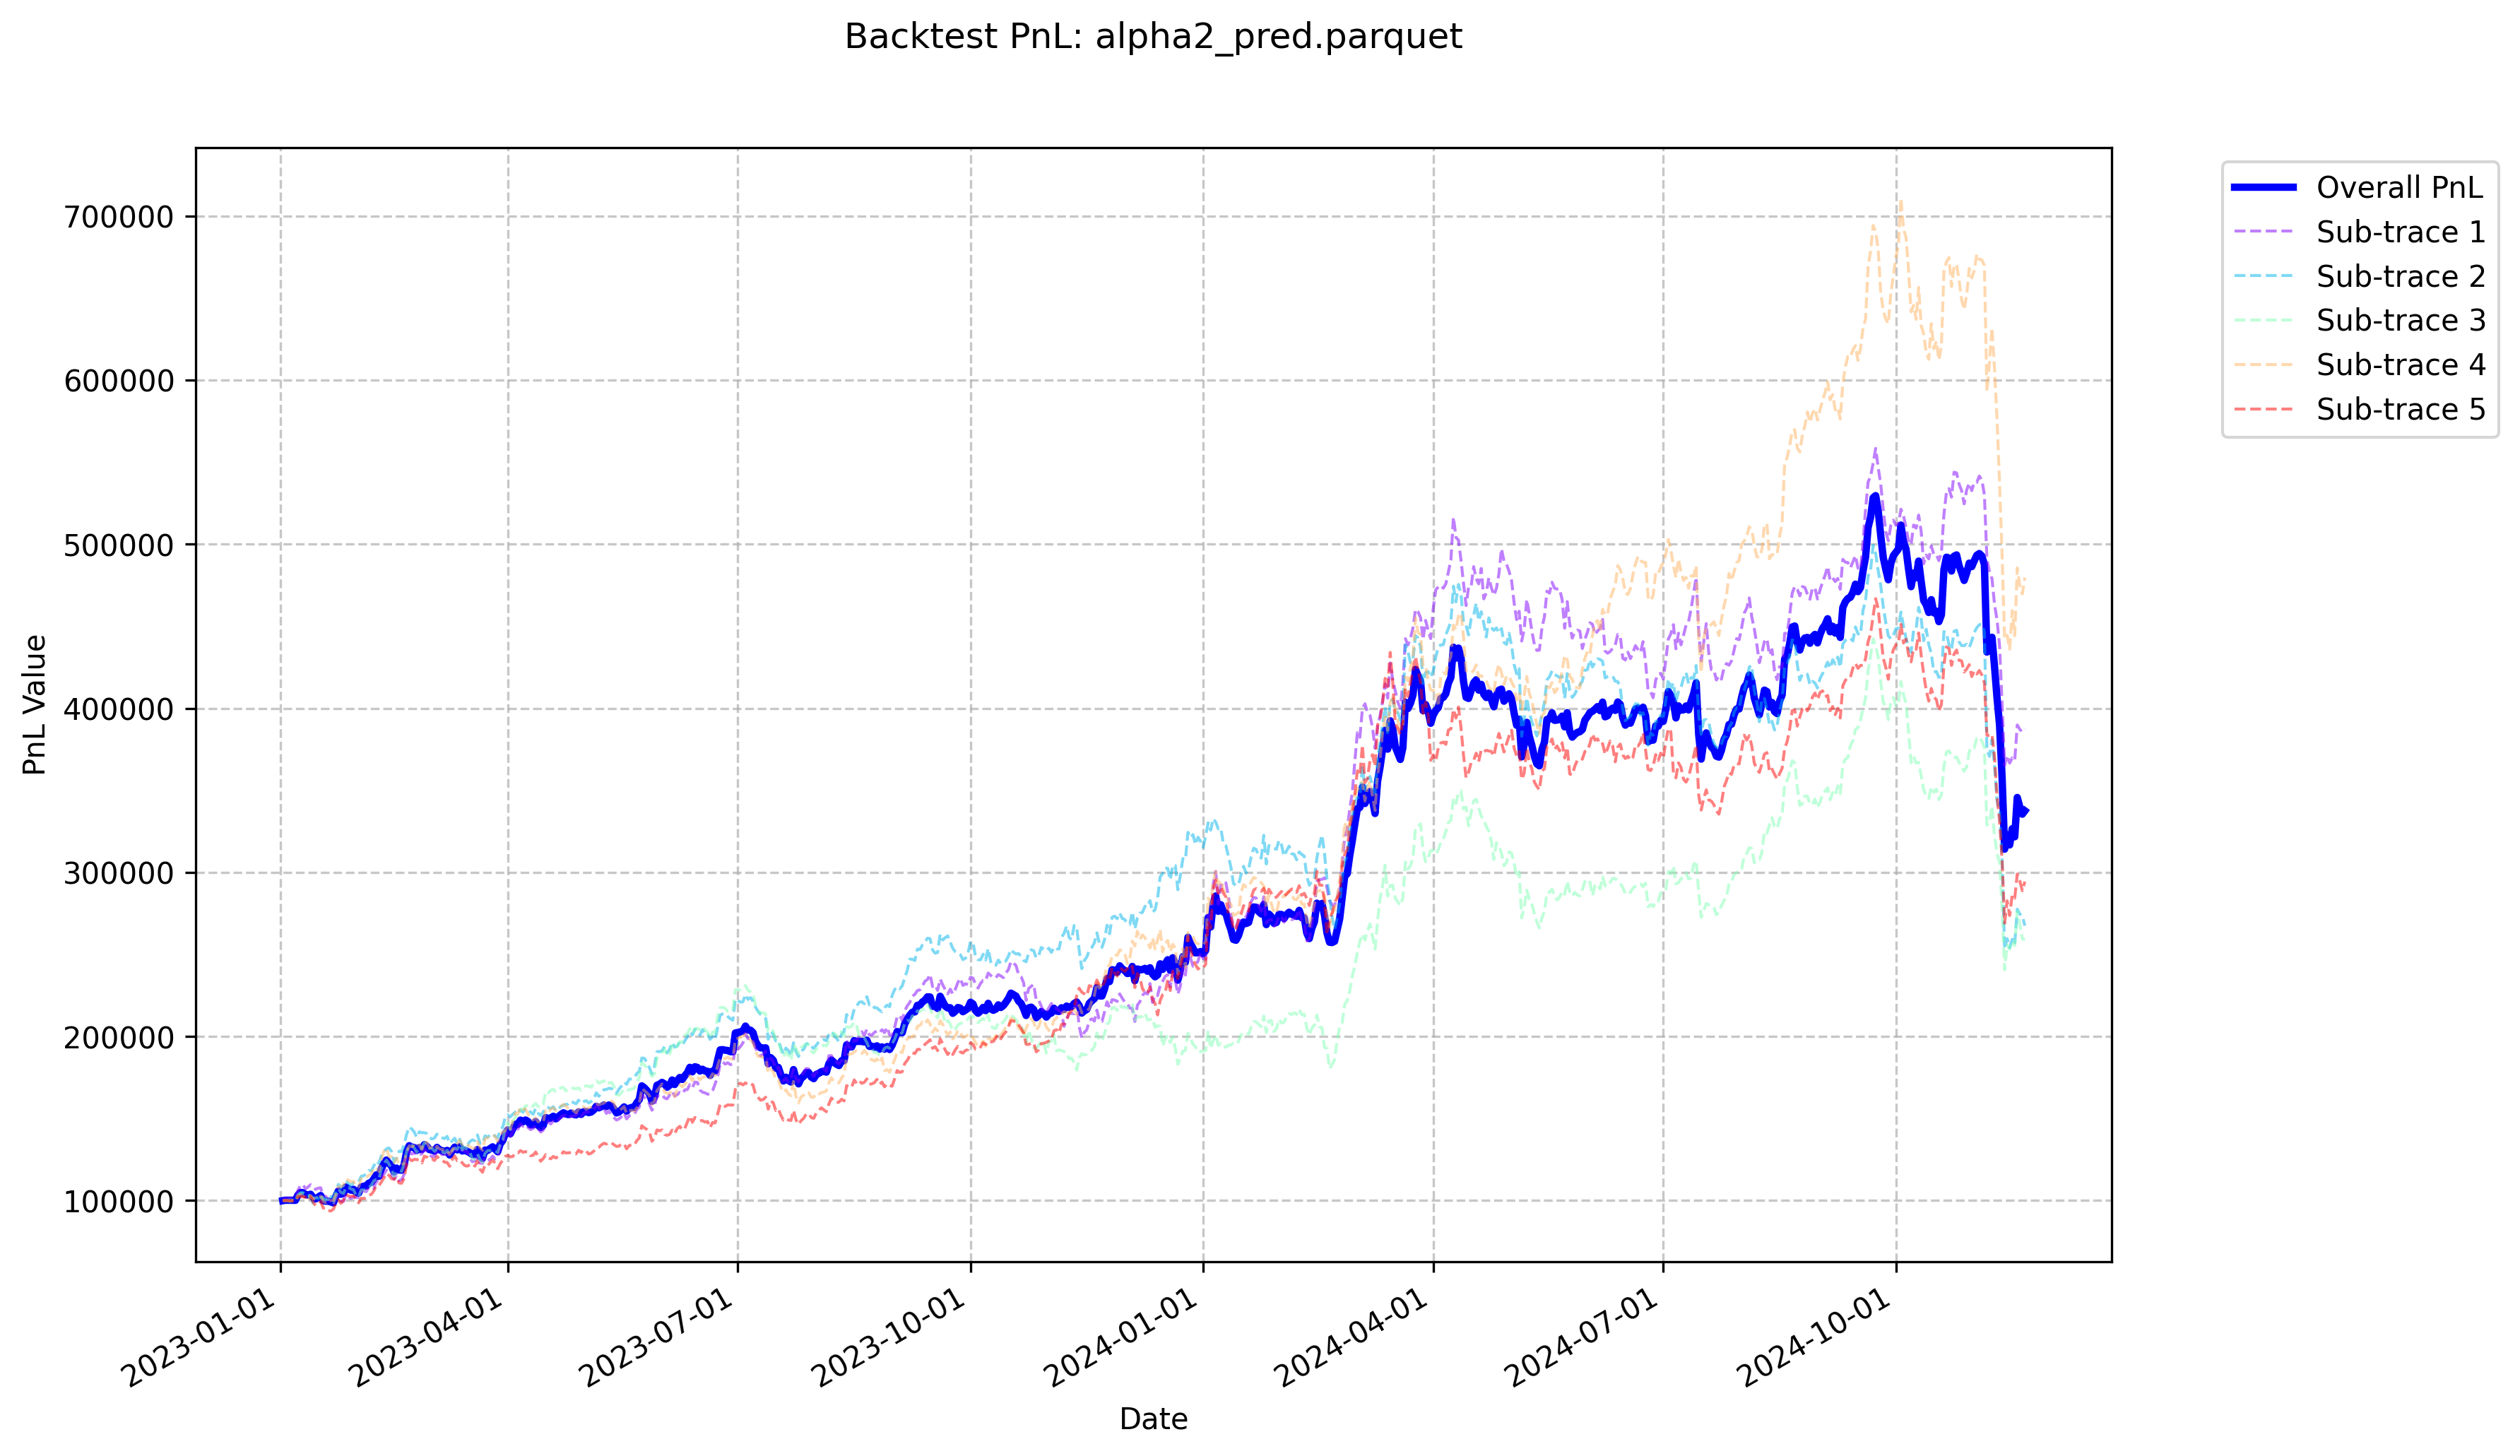

In [22]:
from backtest.backtest import main_backtest, show_plot
from backtest.config import BacktestConfig

day_num = 5
config = BacktestConfig(
    input_df_path = output_path,
    delist_info_path='/home/dp/backup_crypto/crypto/src/backtest/delist/delist_info.csv',
    trade_factor_name = f"linear_compound_factor_{day_num}day",
    update_position_time = day_num,
)

main_backtest(config)
show_plot(config)

